# Using Logisitic Regression to Predict High-Earners in a Census Dataset

The aim of this program is to use a logistic regression classifier on a census dataset from the USA to predict high earners. The dataset consists of information including age, profession, educational level and capital gains.

We begin by loading the data into a dataframe and assigning the column names.

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import data
df = pd.read_csv('census_train.txt', sep = ', ', header = None, engine = 'python')
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
        'marital_status', 'occupation', 'relationship', 'race', 'sex',
        'capital_gains', 'capital_loss', 'hours_per_week', 'native_country', 'income']
# assign column names
df.columns = cols

Our target variable will be income. There are features that appear irrelevant to our estimator such as 'relationship' and 'final weight' (census). The education feature is replicated in another numerical column and the native country information has little predictive power as most individuals are from the US. Therefore, we remove all of these features from the data.

In [55]:
# drop irrelevant and unwanted columns
df = df.drop(['fnlwgt', 'education', 'native_country', 'relationship'], axis = 1)
# check if there are any missing entries in the data
print(df.isnull().sum())

age               0
workclass         0
education_num     0
marital_status    0
occupation        0
race              0
sex               0
capital_gains     0
capital_loss      0
hours_per_week    0
income            0
dtype: int64


So the data has no missing values, but on further inspection we notice that it does contain question marks '?' to represent missing or unknown values. There are several ways we can deal with these values, including imputation, but we will opt to simply remove any rows containing a '?'. 

In [56]:
# remove any rows containing '?'
cols2 = df.columns
for col in cols2:
    # get indexes of column where value is '?'
    indexes = df[df[col] == '?'].index
    # drop all rows given by 'indexes'
    df.drop(indexes, inplace = True)

As the data contains thousands of samples, it can be helpful to produce boxplots to get a feel for the demographics.

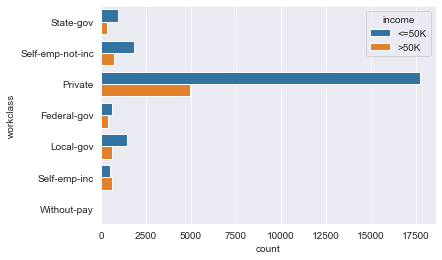

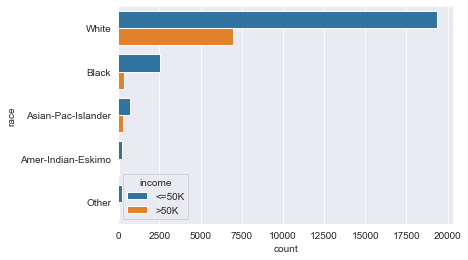

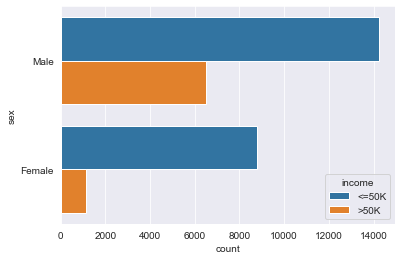

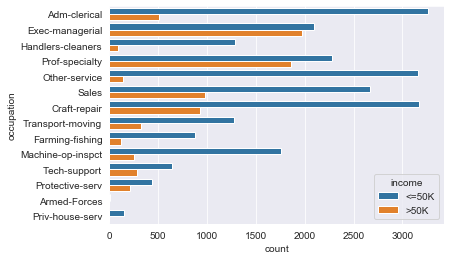

In [57]:
# create countplots of observations
sns.set_style('darkgrid')
plt.figure()
sns.countplot(y = 'workclass', data = df, hue = 'income')
plt.figure()
sns.countplot(y = 'race', data = df, hue = 'income')
plt.figure()
sns.countplot(y = 'sex', data = df, hue = 'income')
plt.figure()
sns.countplot(y = 'occupation', data = df, hue = 'income')
plt.show()

Most of the the individuals in this census sample are employed in the private sector. Most individuals are white and there are more males than females. The majority of high-earners are employed in executive-managerial roles and the professional-speciality sector. We could explore these avenues in depth if we so desired.

We are going to be using regularisation with this logistic regression model. It is important that we rescale the features as the capital_gains and capital_loss columns in particular possess values several orders of magnitude larger than any values found in the other numeric columns. Our approach will be to separate the numeric and categorical data, (standard) scaling the former and generating binary columns for the latter, before recombining.

In [58]:
# assign the features to X
X = df.drop('income', axis = 1)
# assign the target variable y (income)
y = pd.get_dummies(df['income'], drop_first = True)

# split data into training and testing data before scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# select numeric and categorical data from X_train
num_indexes = ['age', 'education_num', 'capital_gains', 'capital_loss',
               'hours_per_week']
num_data = X_train[num_indexes]
cat_data = X_train.drop(num_data.columns, axis = 1)

# select categorical data from X_test
cat_data2 = X_test.drop(num_data.columns, axis = 1)

# with the scaler fit to and transform the training features, and transform the testing features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_indexes])
X_test_scaled = scaler.transform(X_test[num_indexes])                                                    
                       
# convert categorical data into binary columns
cat_cols = cat_data.columns
for cat in cat_cols:
    # generate binary columns, remembering to drop one of the created columns as they are collinear
    new_col = pd.get_dummies(cat_data[cat], drop_first = True)
    # add new columns to df
    cat_data = pd.concat([cat_data, new_col], axis = 1)
    # drop original columns
    cat_data = cat_data.drop(cat, axis = 1)
# convert into np array
new_data = np.array(cat_data)
# combine with the scaled numerical data
X_train_final = np.concatenate((X_train_scaled, new_data), axis = 1)

# do the same for X_test
for cat in cat_cols:
    # generate binary columns, remembering to drop one of the created columns as they are collinear
    new_col = pd.get_dummies(cat_data2[cat], drop_first = True)
    # add new columns to df
    cat_data2 = pd.concat([cat_data2, new_col], axis = 1)
    # drop original columns
    cat_data2 = cat_data2.drop(cat, axis = 1)
# convert into np array
new_data2 = np.array(cat_data2)
# combine with the scaled numerical data
X_test_final = np.concatenate((X_test_scaled, new_data2), axis = 1)

# reshape for sklearn
y_train = np.array(y_train)
y_train = y_train.reshape(y_train.shape[0],)

We are going to use Ridge regression, which utilises the reguarisation parameter $\alpha$ in the regularised cost function. In sklearn, the $C$ parameter is used where $C = \frac{1}{\alpha}$. We will define a grid of values for $C$ and perform a cross-validated gridsearch to find the value for optimal model performance. 

In [59]:
# find the optimal C value
# create logistic regressor
log_reg = LogisticRegression(penalty = 'l2', solver = 'liblinear')
c_space = np.logspace(-1, 3, 50)
param_grid = {'C': c_space}
# perform gridsearch cross-validation
log_reg_cv = GridSearchCV(log_reg, param_grid, cv = 5)
# fit to the training data
log_reg_cv.fit(X_train_final, y_train)
print('Tuned Logistic Regression Parameter: {}'.format(log_reg_cv.best_params_))
print('Tuned Logistic Regression Accuracy: {:.2f}'.format(log_reg_cv.best_score_))

Tuned Logistic Regression Parameter: {'C': 0.1757510624854792}
Tuned Logistic Regression Accuracy: 0.85


A small $C$ value is selected, so we know that the model is using a large $\alpha$. This has the effect of minimising the coefficients, and reduces overfitting to the training data. The resulting decision boundary will be less complex.

Now we can make predictions on the test data. The confusion matrix indicates the performance of the model and has as elements the numbers of true positive, false positive, true negative, and false negative classifications. The classification report displays the precision, recall, and F-score for the model.

In [60]:
log_reg_optimal = log_reg_cv.best_estimator_
# predict y_test
y_pred = log_reg_optimal.predict(X_test_final)
# generate confusion matrix
print(confusion_matrix(y_test, y_pred))
# generate classification report
print(classification_report(y_test, y_pred))

[[4286  318]
 [ 616  924]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4604
           1       0.74      0.60      0.66      1540

    accuracy                           0.85      6144
   macro avg       0.81      0.77      0.78      6144
weighted avg       0.84      0.85      0.84      6144



Another useful tool for evaluating a logistic regression classifier is the Receiver Operating Characteristic (ROC) curve, which is a plot of the true positive rate vs false positive rate as the hypothesis function threshold is varied. The Area Under the Curve (AUC) score gives a general indication of model performance. 

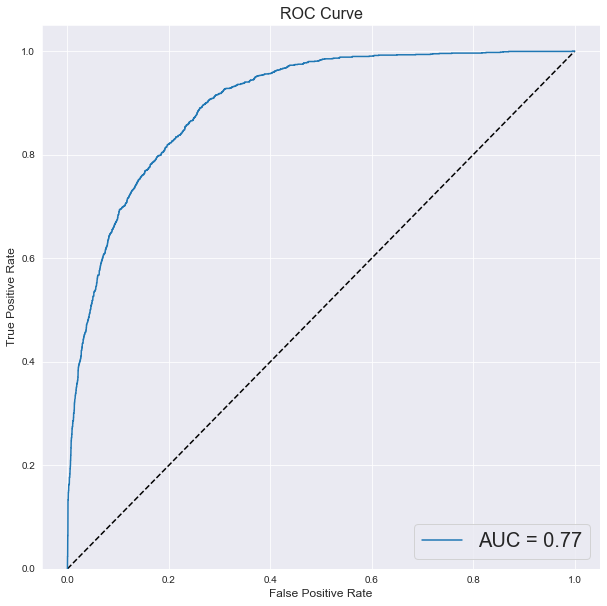

In [61]:
# generate plot
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate', fontsize = 12)
ax.set_ylabel('True Positive Rate', fontsize = 12)
ax.set_title('ROC Curve', fontsize = 16)
ax.set_ylim(0,)

# plot ROC curve
# get probabilities that y_test is predicted 1
y_pred_prob = log_reg_optimal.predict_proba(X_test_final)[:,1]
# get false positive and true positive rates
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# compute area under curve score
auc_score = roc_auc_score(y_test, y_pred)
# plot ROC curve on ax
ax.plot(fpr, tpr, label = 'AUC = {:.2f}'.format(auc_score))
plt.legend(loc = 'lower right', prop = {'size': 20})
plt.show()

To finish, we can get a rough idea of the most important features in the model. That is, the features that most strongly predict high income earners. We do this by plotting the feature coefficients, which will typically be larger for features with greater predictive power. Positive values will be more predictive of higher-earners, whereas negative values will be more predictive of lower-earners.

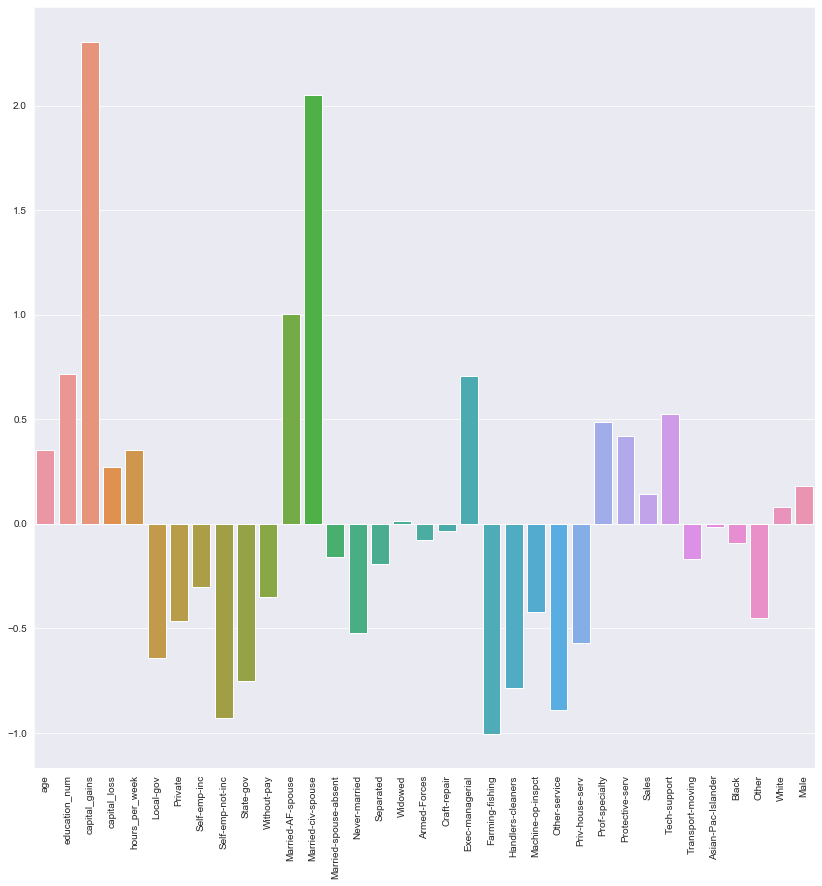

In [62]:
# get numerical data names
num_data_names = X_train[num_indexes].columns
# get categorical data names
cat_data_names = cat_data.columns
# combine
all_names = np.append(num_data_names, cat_data_names)

# get coefficients and plot
coeffs = log_reg_optimal.coef_[0]
plt.figure(figsize = (14, 14))
bar_names = X.columns
sns.barplot(all_names, coeffs)
plt.xticks(rotation = 90)
plt.show()